# Take a glance

In [1]:
%bq tables list

In [2]:
%bq tables view -n kkbox-210108.kk_Data.user_label_201703

msno,is_churn
++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=,0
+/HS8LzrRGXolKbxRzDLqrmwuXqPOYixBIPXkyNcKNI=,0
+/g9O3USecrC8npzaFHXW/2XJ7fB80SineiUoCg7M6o=,0
+/namlXq+u3izRjHCFJV4MgqcXcLidZYszVsROOq/y4=,0
+0/X9tkmyHyet9X80G6GTrDFHnJqvai8d1ZPhayT0os=,0
+09YGn842g6h2EZUXe0VWeC4bBoCbDGfUboitc0vIHw=,0
+0l+FDuhyjaZnu0APnrg5L9QqgaRw4RmdQMvqOtKDmU=,0
+0l/WkoOIugT69NYawwewSLZjIJ17kHIpDdWqcp53RI=,0
+2Df04hr61UUJijMM2xR97gtoQWWDJpnJVKQ7VMYN9o=,0
+2KZws+cYLzerLNA6dgCOpxKysRv4BQ8SiKtA0rV4QE=,0


In [3]:
%bq query -n check
# -- uni, not_null, quantiles
SELECT COUNT(DISTINCT msno) AS uni_msno, COUNT(msno) AS not_null_msno,
       APPROX_QUANTILES(is_churn, 3) AS is_churn_quantiles
FROM `kkbox-210108.kk_Data.user_label_201703`

In [71]:
%bq dryrun -q check

In [69]:
%bq execute -q check

uni_msno,not_null_msno,is_churn_quantiles
886500,886500,"[0, 0, 0, 1]"


In [78]:
%bq query -n agg_result 
# is_churn distribution
SELECT COUNT(msno) AS is_churn_count
FROM `kkbox-210108.kk_Data.user_label_201703`
GROUP BY is_churn

In [79]:
%bq dryrun -q agg_result

In [88]:
# python packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# ignore warning
import warnings
warnings.filterwarnings("ignore")

In [89]:
# square scale
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """

    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)
'''
fig, ax = plt.subplots(1)

ax.plot(np.arange(0, 9)**2, label='$y=x^2$')
ax.legend()

ax.set_yscale('squareroot')
ax.set_yticks(np.arange(0,9,2)**2)
ax.set_yticks(np.arange(0,8.5,0.5)**2, minor=True)

plt.show()
''';

In [4]:
# pandas
query = """ 
SELECT COUNT(msno) AS is_churn_count
FROM `kkbox-210108.kk_Data.user_label_201703`
GROUP BY is_churn
        """
df = pd.read_gbq(query,project_id='kkbox-210108',dialect='standard')

Requesting query... ok.
Job ID: fad83037-a38f-41d4-ab50-fe1200e2d239
Query running...
Query done.
Processed: 45.7 MB Billed: 46.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 2 rows.

Total time taken 3.11 s.
Finished at 2018-09-18 08:50:37.


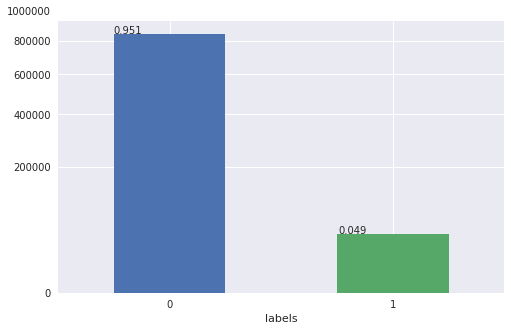

In [29]:
# give labels
df_is_churn = df.reset_index().rename(columns={'index':'labels'})
# plot
ax = df_is_churn.plot(kind='bar', x='labels',y='is_churn_count',legend=False,figsize=(8,5))
plt.xticks(rotation=0)
ax.set_yscale('squareroot')
# ticks the ratio
for p in ax.patches[:4]:
    ax.annotate('%.3f' % (p.get_height()/ df_is_churn.is_churn_count.sum()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [4]:
%bq tables view -n kkbox-210108.kk_Data.user_logs

msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
8nSyuVdv8qR4aHr1hUx1FXoIuxpZluW+kR/d0ounuYA=,20160512,24,2,1,1,53,61,15019.365
d2GtIMHD45Ri5/Ksa86X4FYWCZMM3fZ4WRDKjbhp15A=,20160205,81,2,4,3,34,74,9600.676
d2GtIMHD45Ri5/Ksa86X4FYWCZMM3fZ4WRDKjbhp15A=,20161124,37,4,4,2,48,83,12778.431
d2GtIMHD45Ri5/Ksa86X4FYWCZMM3fZ4WRDKjbhp15A=,20170114,113,22,8,3,40,163,14347.198
kb3qHtlz+K4Ume8TF4FQi9xwrTZqzFFvBDZsdYvyQ0A=,20161217,32,1,0,1,30,58,7391.719
B/eZk3P+A98+vport4EL6KBRhYiioS+F1uVJSGmAUGw=,20150720,22,2,0,2,38,52,10062.741
ysLUp9Ebqx3RrCNmZAOSmyW7kDZQafvyg7+Ge6lbG3Y=,20150717,38,6,5,4,66,87,20265.215
ysLUp9Ebqx3RrCNmZAOSmyW7kDZQafvyg7+Ge6lbG3Y=,20160318,36,4,2,4,97,61,24174.545
65MC0qTNLb/tG6fPv0IN7AzLqma4IkDHe1SEB8TedA8=,20150411,42,24,13,6,85,131,26109.762
aDyAkp8ZPYJUAVISQZ9oe1/2Ub1iDbq1Z9B6lBaTGRk=,20150107,23,12,3,7,60,90,19544.564


In [64]:
%bq query -n check
# -- uni, not_null, quantiles
SELECT COUNT(date) AS not_null_date, COUNT(num_25) AS not_null_25,COUNT(num_50) AS not_null_50,
       COUNT(num_75) AS not_null_75,COUNT(num_985) AS not_null_985,COUNT(num_100) AS not_null_100,
       COUNT(num_unq) AS not_null_nuq, COUNT(total_secs) AS not_null_total_secs
FROM `kkbox-210108.kk_Data.user_logs`

In [65]:
%bq dryrun -q check

In [34]:
%bq execute -q check

not_null_date,not_null_25,not_null_50,not_null_75,not_null_985,not_null_100,not_null_nuq,not_null_total_secs
410502905,410502905,410502905,410502905,410502905,410502905,410502905,410502905


In [72]:
%bq query -n check
SELECT APPROX_QUANTILES(num_25,3) AS quant 
FROM `kkbox-210108.kk_Data.user_logs`
UNION ALL
SELECT APPROX_QUANTILES(num_50,3) AS quant
FROM `kkbox-210108.kk_Data.user_logs`

In [73]:
%bq dryrun -q check

In [49]:
%bq query -n check
# -- quantiles num ARRAY CTE dtyle = int64
WITH Quant_Num_ARRAY AS(
                   SELECT APPROX_QUANTILES(num_25,4) AS quant 
                   FROM `kkbox-210108.kk_Data.user_logs`      UNION ALL
                   SELECT APPROX_QUANTILES(num_50,4) AS quant 
                   FROM `kkbox-210108.kk_Data.user_logs`      UNION ALL 
                   SELECT APPROX_QUANTILES(num_75,4) AS quant 
                   FROM `kkbox-210108.kk_Data.user_logs`       UNION ALL 
                   SELECT APPROX_QUANTILES(num_985,4) AS quant 
                   FROM `kkbox-210108.kk_Data.user_logs`       UNION ALL
                   SELECT APPROX_QUANTILES(num_100,4) AS quant 
                   FROM `kkbox-210108.kk_Data.user_logs`       UNION ALL
                   SELECT APPROX_QUANTILES(num_unq,4) AS quant 
                   FROM `kkbox-210108.kk_Data.user_logs`)

# -- quantiles sec ARRAY CTE dtype = double
, Quant_Secs_ARRAY AS(
                   SELECT APPROX_QUANTILES(total_secs,4)  AS quant_secs 
                   FROM `kkbox-210108.kk_Data.user_logs`)

SELECT quant[OFFSET(0)] AS min, quant[OFFSET(1)] AS Q1,
       quant[OFFSET(2)] AS Q2,  quant[OFFSET(3)] AS Q4,
       quant[OFFSET(4)] AS max
FROM Quant_Num_ARRAY

UNION ALL

SELECT ROUND(quant_secs[OFFSET(0)]) AS min, ROUND(quant_secs[OFFSET(1)]) AS Q1,
       ROUND(quant_secs[OFFSET(2)]) AS Q2,  ROUND(quant_secs[OFFSET(3)]) AS Q4,
       ROUND(quant_secs[OFFSET(4)]) AS max
FROM Quant_Secs_ARRAY

In [3]:
%bq dryrun -q check

In [120]:
%bq execute -q check

min,Q1,Q2,Q4,max
0.0,0.0,1.0,2.0,1710.0
0.0,0.0,2.0,7.0,18798.0
0.0,0.0,0.0,1.0,1690.0
0.0,0.0,0.0,1.0,2747.0
0.0,6.0,17.0,38.0,42004.0
1.0,8.0,19.0,40.0,4925.0
-9223372036854776.0,1888.0,4615.0,10237.0,9223372036854776.0


In [55]:
# Alternative way to get describe_dataframe instead of using read_gbq
df_describe_2 = %bq execute -q check --to-dataframe
# assign feature name
df_describe_2.insert(loc=0,column='feature',
          value=['num_50','num_25','num_75','num_985','num_100','num_unq','total_sec'])

# show it clearly
pd.set_option('display.float_format', lambda x: '%.1f' % x)
df_describe_2 = df_describe_2.reindex(index=[1,0,2,3,4,5,6])
df_describe_2

,feature,min,Q1,Q2,Q4,max
1,num_25,0.0,0.0,1.0,2.0,1710.0
0,num_50,0.0,0.0,2.0,7.0,18798.0
2,num_75,0.0,0.0,0.0,1.0,2747.0
3,num_985,0.0,0.0,0.0,1.0,1690.0
4,num_100,0.0,6.0,17.0,38.0,42004.0
5,num_unq,1.0,8.0,19.0,40.0,4925.0
6,total_sec,-9223372036854776.0,1875.0,4593.0,10216.0,9223372036854776.0


In [8]:
%bq query -n query
-- user_latent_satisfaction CTE
WITH feature AS(
                SELECT msno, AVG(single_day_latent_satisfaction) AS user_latent_satisfaction
                FROM( 
                     SELECT msno, ( num_100 / (num_25 + num_50 + num_75 + num_985 + num_100) ) AS single_day_latent_satisfaction
                     FROM `kkbox-210108.kk_Data.user_logs`
                     WHERE date > 20160901 AND date < 20170228 )
                GROUP BY msno)
SELECT train.msno, feature.user_latent_satisfaction
FROM `kkbox-210108.kk_Data.user_label_201703` AS train
LEFT JOIN feature
ON  train.msno = feature.msno

In [9]:
%bq dryrun -q query

In [10]:
%bq extract -f csv -H -p 'gs://kk_data/ft_satisfaction.csv' -q query --verbose

Job kkbox-210108/job_cTsYQOhjaqTiYDWvwyJBYwBPmQuD completed

In [90]:
# storage
from google.datalab import Context
import google.datalab.bigquery as bq
try:
  from StringIO import StringIO
except ImportError:
  from io import BytesIO as StringIO

In [91]:
%gcs read --object gs://kk_data/ft_satisfaction.csv -v df_ft_satis

In [92]:
df_ft_satis = pd.read_csv(StringIO(df_ft_satis))
df_ft_satis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886500 entries, 0 to 886499
Data columns (total 2 columns):
msno                        886500 non-null object
user_latent_satisfaction    732868 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.5+ MB


In [14]:
%bq query -n query
-- day_listen CTE
WITH features AS (
                   SELECT  msno AS msno , COUNT(msno) AS day_listen
                   FROM `kkbox-210108.kk_Data.user_logs`
                   WHERE date > 20160901 AND date < 20170228 
                   GROUP BY msno)
SELECT train.msno, train.is_churn, features.day_listen
FROM `kkbox-210108.kk_Data.user_label_201703` AS train
LEFT JOIN features 
        ON   train.msno = features.msno 

In [15]:
%bq dryrun -q query

In [16]:
%bq extract -f csv -H -p 'gs://kk_data/ft_day_listen.csv' -q query --verbose

Job kkbox-210108/job_fSngWcSPyAcIIB2ppOBAfKUPue23 completed

In [93]:
%gcs read --object gs://kk_data/ft_day_listen.csv -v df_ft_day_listen

In [94]:
df_ft_day_listen = pd.read_csv(StringIO(df_ft_day_listen))

In [95]:
df_train = pd.merge(df_ft_day_listen, df_ft_satis, how='left',on=['msno'])

## Testing set

In [20]:
%bq query -n query
-- user_latent_satisfaction CTE
WITH feature AS(
                SELECT msno, AVG(single_day_latent_satisfaction) AS user_latent_satisfaction
                FROM( 
                     SELECT msno, ( num_100 / (num_25 + num_50 + num_75 + num_985 + num_100) ) AS single_day_latent_satisfaction
                     FROM `kkbox-210108.kk_Data.user_logs`
                     WHERE date > 20160901 AND date < 20170228 )
                GROUP BY msno)
SELECT sub.msno, feature.user_latent_satisfaction
FROM `kkbox-210108.kk_Data.submission` AS sub
LEFT JOIN feature
ON  sub.msno = feature.msno

In [21]:
%bq dryrun -q query

In [22]:
# to storage then read 
# ~ 18s
%bq extract -f csv -H -p 'gs://kk_data/sub_ft_satisfaction.csv' -q query --verbose

Job kkbox-210108/job_ytTQ6KaT97bHbmJ-VnwXyyQu_9ew completed

In [23]:
%bq query -n query
WITH features AS (
                   SELECT  msno AS msno , COUNT(msno) AS day_listen
                   FROM `kkbox-210108.kk_Data.user_logs`
                   -- Filter 20160201 , 20170228
                   WHERE date > 20160901 AND date < 20170228 
                   GROUP BY msno)
SELECT sub.msno, sub.is_churn, features.day_listen
FROM `kkbox-210108.kk_Data.submission` AS sub
LEFT JOIN features 
        ON   sub.msno = features.msno 

In [24]:
%bq dryrun -q query

In [25]:
# to storage then read 
# ~ 18s
%bq extract -f csv -H -p 'gs://kk_data/sub_ft_day_listen.csv' -q query --verbose

Job kkbox-210108/job_MXKTnPRwWvQlDLH0dlD9HExJnq3x completed

In [269]:
# del df_sub, df_sub_ft_satis, df_sub_ft_day_listen

In [96]:
# ~ 1.5 s 
%gcs read --object gs://kk_data/sub_ft_satisfaction.csv -v df_sub_ft_satis

In [97]:
# ~ 1.5 s 
%gcs read --object gs://kk_data/sub_ft_day_listen.csv -v df_sub_ft_day_listen

In [98]:
df_sub_ft_day_listen = pd.read_csv(StringIO(df_sub_ft_day_listen))
df_sub_ft_satis = pd.read_csv(StringIO(df_sub_ft_satis))

In [99]:
df_sub = pd.merge(df_sub_ft_day_listen, df_sub_ft_satis, how='left',on=['msno'])
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907471 entries, 0 to 907470
Data columns (total 4 columns):
msno                        907471 non-null object
is_churn                    907471 non-null int64
day_listen                  726084 non-null float64
user_latent_satisfaction    726084 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 34.6+ MB


# Fast EDA

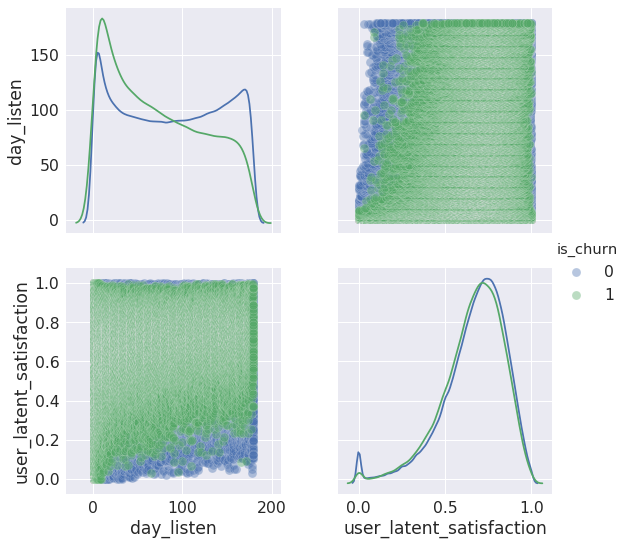

In [100]:
sns.set(font_scale=1.56)
sns.pairplot(df_train.dropna(),vars=['day_listen','user_latent_satisfaction'],\
             diag_kind='kde',hue='is_churn',plot_kws = {'alpha': 0.4, 's': 80},size = 4)

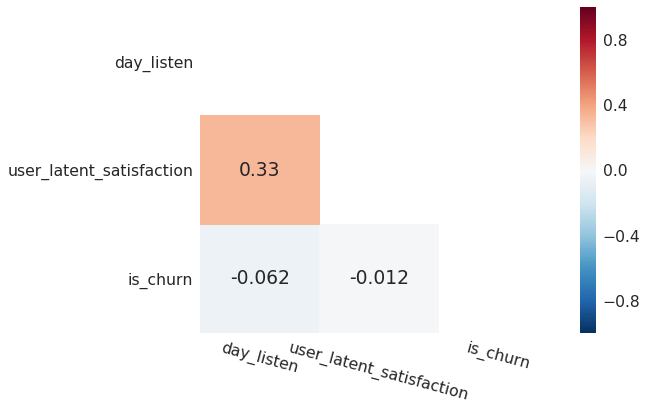

In [42]:
# heat map 
corr_matrix = df_train[['day_listen','user_latent_satisfaction','is_churn']].corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize=(8,6))
  corr_map = sns.heatmap(corr_matrix,mask=mask,annot=True,ax=ax)
  plt.xticks(rotation=-15
            )

# Missing Value Strategy

## Missing data summary

In [101]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print('training set:')
print(''*60)
print(df_train.isnull().sum() / len(df_train))
print('_'*60)
print('testing set:')
print(''*60)
print(df_sub.isnull().sum() / len(df_sub))

training set:

msno                       0.000
is_churn                   0.000
day_listen                 0.173
user_latent_satisfaction   0.173
dtype: float64
____________________________________________________________
testing set:

msno                       0.000
is_churn                   0.000
day_listen                 0.200
user_latent_satisfaction   0.200
dtype: float64


# Day_listen

## Making bins

In [103]:
# filling na with -1
df_train[['day_listen','user_latent_satisfaction']] = df_train[['day_listen','user_latent_satisfaction']].fillna(-1)
df_sub[['day_listen','user_latent_satisfaction']] = df_sub[['day_listen','user_latent_satisfaction']].fillna(-1)
# place nan in testing set
df_sub['is_churn'] = np.nan
# combine 
df_data = df_train.append(df_sub)

In [55]:
# training set 
# df_data[:len(df_train)].is_churn.isnull().any()
# testing set 
# (df_data[len(df_train):].is_churn == -1).all() 
# df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]

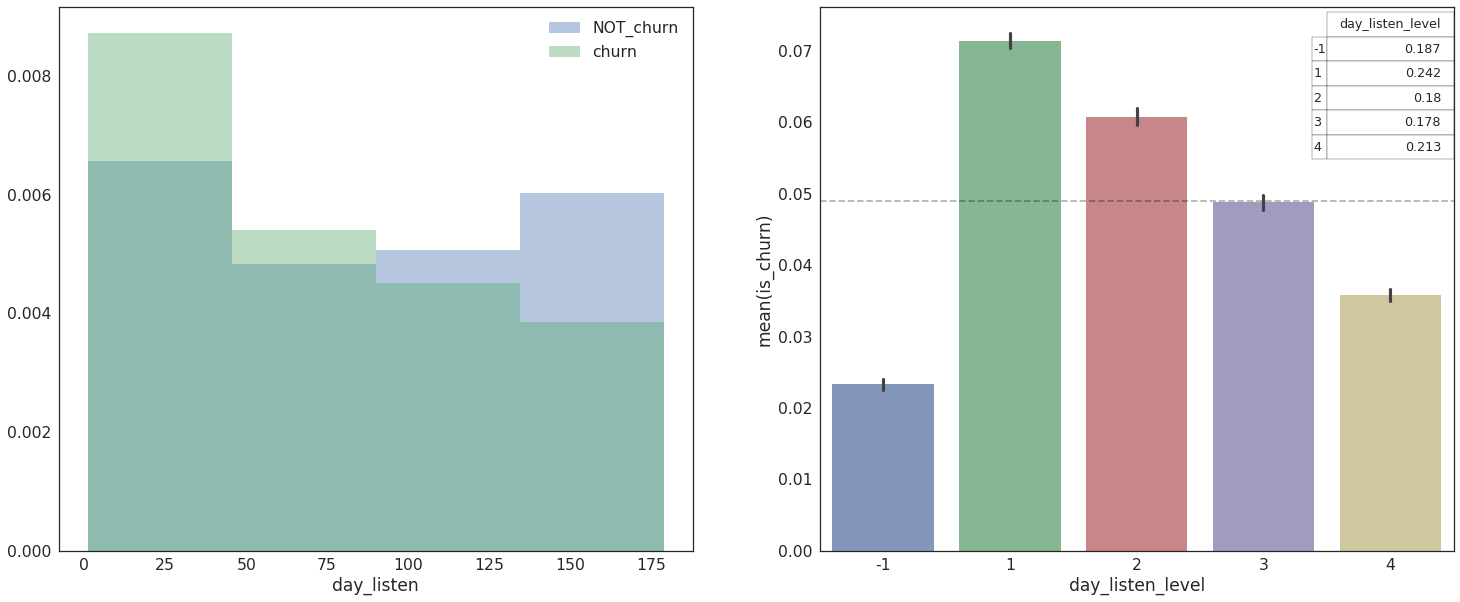

In [105]:
# cut into bins
bins = 4

df_data.loc[(df_data.day_listen >= 0),'day_listen_level'] = pd.cut(df_data.loc[(df_data.day_listen >= 0),'day_listen'], bins,labels=[1,2,3,4])
df_data.day_listen_level = df_data.day_listen_level.fillna(-1)

# prepare table (% of each value)
from pandas.plotting import table
df_percent = pd.DataFrame( df_data.day_listen_level.value_counts().sort_index() / len(df_data) ).round(3) 

# distribution

with sns.axes_style('white'):
  fig, [ax1,ax2] = plt.subplots(1,2, figsize=(25,10))
  sns.distplot(df_data.loc[(df_data.is_churn == 0) & (df_data.day_listen >= 0), 'day_listen'],kde=False, bins=bins, label='NOT_churn',ax=ax1,norm_hist=True)
  sns.distplot(df_data.loc[(df_data.is_churn == 1)& (df_data.day_listen >= 0), 'day_listen'],kde=False, bins=bins, label='churn',ax=ax1,norm_hist=True)
  ax1.legend()
  
# barplot with churn_rate plus df_percent table
  sns.barplot(x='day_listen_level', y='is_churn', data=df_data,ax=ax2,alpha=.75)
  ax2.axhline(0.049,linestyle='dashed',c='black',alpha=.3)
  table(ax2, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

# Model Testing

In [106]:
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb

print(df_train.columns)
print(df_sub.columns)

Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction',
       'day_listen_level'],
      dtype='object')
Index(['msno', 'is_churn', 'day_listen', 'user_latent_satisfaction',
       'day_listen_level'],
      dtype='object')


In [107]:
day_lis_bins = ['msno','day_listen_level','is_churn']
day_lis = ['msno','day_listen','is_churn']

In [108]:
def model_training_rf(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # Training ~ 01:45s
  model = RandomForestClassifier(random_state=2,n_estimators=300,
                           min_samples_split=0.05,n_jobs=-1,class_weight={0 :0.45,1 :0.55})
  model.fit(X_train,Y_train)
  
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [109]:
orginal_day_listen_model, orginal_day_listen_val_score,\
orginal_day_listen_pred = model_training_rf(df_train[day_lis],df_sub[day_lis])

day_listen_bins_model, day_listen_bins_val_score,\
day_listen_bins_pred = model_training_rf(df_train[day_lis_bins],df_sub[day_lis_bins])

In [73]:
# saving result and committing

orginal_day_listen_pred.to_csv("/content/datalab/sub_orginal_day_listen_pred.csv", index=False)

!gsutil cp '/content/datalab/sub_orginal_day_listen_pred.csv' 'gs://kk_data/submission/sub_orginal_day_listen_pred.csv';


day_listen_bins_pred.to_csv("/content/datalab/sub_day_listen_bins_pred.csv", index=False)

!gsutil cp '/content/datalab/sub_day_listen_bins_pred.csv' 'gs://kk_data/submission/sub_day_listen_bins_pred.csv';


Copying file:///content/datalab/sub_orginal_day_listen_pred.csv [Content-Type=text/csv]...
- [1 files][ 56.4 MiB/ 56.4 MiB]                                                
Operation completed over 1 objects/56.4 MiB.                                     
Copying file:///content/datalab/sub_day_listen_bins_pred.csv [Content-Type=text/csv]...
- [1 files][ 56.6 MiB/ 56.6 MiB]                                                
Operation completed over 1 objects/56.6 MiB.                                     


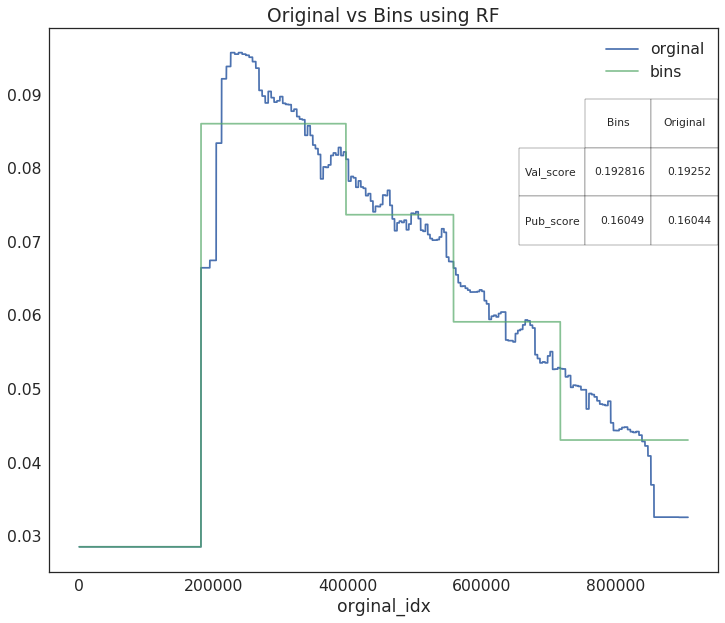

In [111]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
df_score = pd.DataFrame({'Original':[np.around(orginal_day_listen_val_score,decimals=6),0.16044],
                             'Bins':[np.around(day_listen_bins_val_score,decimals=6),0.16049]})
df_score.index=['Val_score','Pub_score']

# without bins
orginal_day_listen_pred_plotting = orginal_day_listen_pred
orginal_day_listen_pred_plotting['orginal_idx'] = orginal_day_listen_pred_plotting.index

# bins 
day_listen_bins_pred_plotting = day_listen_bins_pred
day_listen_bins_pred_plotting['orginal_idx'] = day_listen_bins_pred_plotting.index

#plot
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize=(12,10))
  orginal_day_listen_pred_plotting.plot(kind='line',x='orginal_idx',y='is_churn',ax=ax,label='orginal')
  day_listen_bins_pred_plotting.plot(kind='line',x='orginal_idx',y='is_churn',ax=ax,alpha=.7,label='bins',title='Original vs Bins using RF')
  table(ax, df_score,bbox=[0.80, 0.60, 0.2, 0.27])

In [113]:
orginal_day_listen_pred.max()

msno           zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=
is_churn                                           0.095659
orginal_idx                                          907470
dtype: object

# User_latent_satisfaction

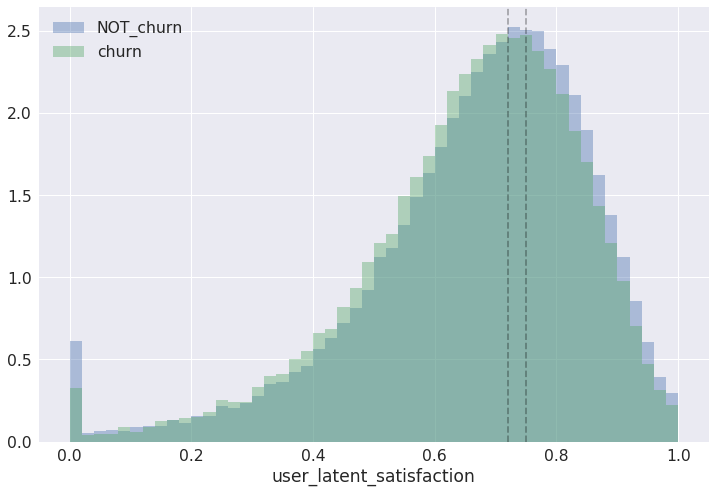

In [130]:
fig,ax = plt.subplots( figsize=(12,8))
sns.distplot(df_data.loc[(df_data.is_churn == 0) & (df_data.day_listen >= 0), 'user_latent_satisfaction'],kde=False,label='NOT_churn',ax=ax,norm_hist=True)
sns.distplot(df_data.loc[(df_data.is_churn == 1)& (df_data.day_listen >= 0), 'user_latent_satisfaction'],kde=False,label='churn',ax=ax,norm_hist=True)
ax.legend()
ax.axvline(0.75,linestyle='dashed',c='black',alpha=.3)
ax.axvline(0.72,linestyle='dashed',c='black',alpha=.3)

# Model Testing

In [137]:
satis = ['msno','day_listen','is_churn','user_latent_satisfaction']

In [147]:
satis_model, satis_val_score,\
satis_pred = model_training_rf(df_train[satis],df_sub[satis])

In [148]:
# saving result and committing

satis_pred.to_csv("/content/datalab/sub_satis_pred.csv", index=False)

!gsutil cp '/content/datalab/sub_satis_pred.csv' 'gs://kk_data/submission/sub_satis_pred.csv';

Copying file:///content/datalab/sub_satis_pred.csv [Content-Type=text/csv]...
- [1 files][ 56.4 MiB/ 56.4 MiB]                                                
Operation completed over 1 objects/56.4 MiB.                                     


In [157]:
print('val_log_loss:', np.around(satis_val_score,decimals=6))
print('pub_log_loss:', '0.160270')

val_log_loss: 0.192158
pub_log_loss: 0.160270
